# Imports

In [1]:
!pip install -U vit-keras

In [3]:
pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 10.0 MB/s 


In [21]:
import random
from datetime import datetime
import numpy as np
import keras 

import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow.keras import layers, regularizers
from tensorflow.keras.losses import BinaryCrossentropy
from keras.models import Sequential
from keras.layers import AveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from vit_keras import vit

import seaborn as sns

import matplotlib.pyplot as plt

# GPU Info

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Nov 30 22:11:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Dataset Setup

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
!mkdir /content/dataset

In [9]:
!unzip '/content/drive/MyDrive/Mestrado/datasets/brain_stroke/brain_data.zip' -d '/content/dataset'

Archive:  /content/drive/MyDrive/Mestrado/datasets/brain_stroke/brain_data.zip
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (20).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (21).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (22).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (23).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (24).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (25).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (26).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (28).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (29).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (30).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (5).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/1

# Hyperparameters Setup

In [23]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
NUM_EPOCHS = 20
CLASS_COUNT = 2

# Model Setup

In [11]:
DF_TRAIN = '/content/dataset/Brain_Data_Organised/Train'
DF_TEST  = '/content/dataset/Brain_Data_Organised/Test'

# images generator
train_gen = ImageDataGenerator(rescale = 1./255,
                               validation_split = 0.2)
test_gen = ImageDataGenerator(rescale = 1./255)

# load training and validating images from directory
train_set = train_gen.flow_from_directory(DF_TRAIN,
                                          subset = 'training',
                                          seed = 956,
                                          shuffle = True,
                                          batch_size = BATCH_SIZE,
                                          target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                          class_mode = 'binary')

valid_set = train_gen.flow_from_directory(DF_TRAIN,
                                          subset = 'validation',
                                          seed = 343,
                                          shuffle = False,
                                          batch_size = BATCH_SIZE,
                                          target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                          class_mode = 'binary')

test_set  = test_gen.flow_from_directory(DF_TEST,
                                         seed = 657,
                                         shuffle = False,
                                         batch_size = BATCH_SIZE,
                                         target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                         class_mode = 'binary')

STEP_SIZE_TRAIN = train_set.n // train_set.batch_size
STEP_SIZE_VALID = valid_set.n // valid_set.batch_size

Found 1801 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Found 250 images belonging to 2 classes.


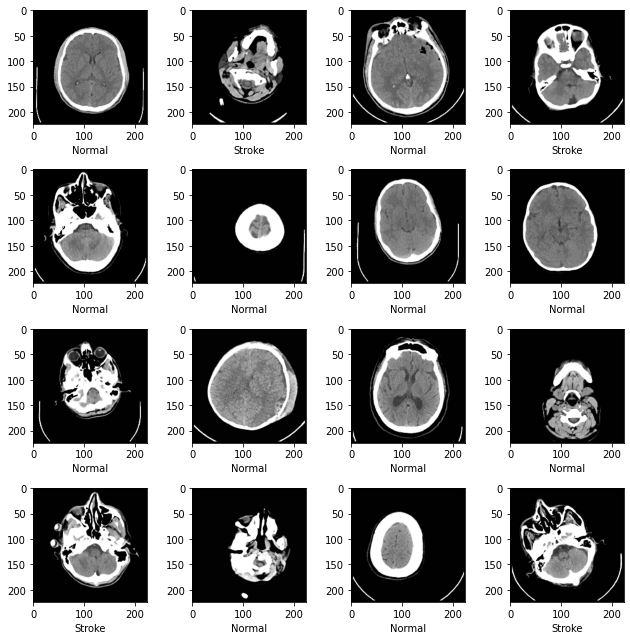

In [12]:
# show images from dataset
images, labels = next(train_set)[:16]
fig, axes = plt.subplots(4, 4, figsize = (9, 9))

axes = axes.flatten()
for img, label, ax in zip(images, labels, axes):
    ax.imshow(img.reshape(IMAGE_SIZE, IMAGE_SIZE, 3))
    ax.set_xlabel(list(train_set.class_indices)[label.astype(int)])
plt.tight_layout()
plt.show()

In [77]:
def get_callbacks(model_name):
    callbacks = []
    tensor_board = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0)
    callbacks.append(tensor_board)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'model.{model_name}.h5', verbose=1, monitor='val_loss', mode='min', save_best_only=True)
    callbacks.append(checkpoint)
    anne = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=2, min_lr=0.0000001, min_delta=0.00001, mode='auto') 
    callbacks.append(anne)
    return callbacks

# EfficientNetB0

## Build Model

In [78]:
# create EfficientNetB0 base model
base_model = tf.keras.applications.EfficientNetB0(
    input_shape = INPUT_SHAPE,
    include_top = False,
    weights = 'imagenet')
base_model.trainable = True

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
predictions = Dense(1, activation = 'sigmoid', name = 'Final')(x)
model = tf.keras.models.Model(inputs = base_model.input, outputs = predictions)

model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_12 (Rescaling)       (None, 224, 224, 3)  0           ['input_16[0][0]']               
                                                                                                  
 normalization_12 (Normalizatio  (None, 224, 224, 3)  7          ['rescaling_12[0][0]']           
 n)                                                                                               
                                                                                           

In [79]:
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999), 
              metrics = metrics)

## Train Model

In [80]:
# train the model
start = datetime.now()
print(datetime.now())

callbacks = get_callbacks('efficientnetb0')
history = model.fit(train_set,
                    epochs = NUM_EPOCHS,
                    validation_data = valid_set,
                    callbacks = [callbacks])

end = datetime.now()
print(end-start)

2021-12-01 00:14:27.609318


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: 0.4723 - tp: 414.0000 - fp: 177.0000 - tn: 964.0000 - fn: 246.0000 - BinaryAccuracy: 0.7651 - precision: 0.7005 - recall: 0.6273 - auc: 0.8395
Epoch 00001: val_loss improved from inf to 0.66472, saving model to model.efficientnetb0.h5
57/57 [==============================] - 28s 301ms/step - loss: 0.4723 - tp: 414.0000 - fp: 177.0000 - tn: 964.0000 - fn: 246.0000 - BinaryAccuracy: 0.7651 - precision: 0.7005 - recall: 0.6273 - auc: 0.8395 - val_loss: 0.6647 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 285.0000 - val_fn: 165.0000 - val_BinaryAccuracy: 0.6333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5235 - lr: 0.0010
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 0.1916 - tp: 593.0000 - fp: 57.0000 - tn: 1084.0000 - fn: 67.0000 - BinaryAccuracy: 0.9311 - precision: 0.9123 - recall: 0.8985 - auc: 0.9763
Epoch 00002: val_loss did not improve from 0.66472
57/57 [==========

## Evaluate Model

In [81]:
# get results
results = model.evaluate(valid_set, steps = len(valid_set), verbose = 1, return_dict = True)

15/15 [==============================] - 1s 89ms/step - loss: 1.9417 - tp: 86.0000 - fp: 21.0000 - tn: 264.0000 - fn: 79.0000 - BinaryAccuracy: 0.7778 - precision: 0.8037 - recall: 0.5212 - auc: 0.7339


In [82]:
# show results
print('EfficientNetB0:')
print('---------------')
print("ACCURACY:",(results['tp']+results['tn'])/(results['tp']+results['tn']+results['fp']+results['fn']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

EfficientNetB0:
---------------
ACCURACY: 0.7777777777777778
Binary Accuracy: 0.7777777910232544
Precision: 0.8037382960319519
Recall: 0.521212100982666
AUC: 0.7339499592781067
F1 Score: 0.6323529195643085


## Predict


Classification Report
              precision    recall  f1-score   support

      Normal       0.66      0.92      0.77       125
      Stroke       0.87      0.53      0.66       125

    accuracy                           0.72       250
   macro avg       0.76      0.72      0.71       250
weighted avg       0.76      0.72      0.71       250

Confusion Matrix
[[115  10]
 [ 59  66]]


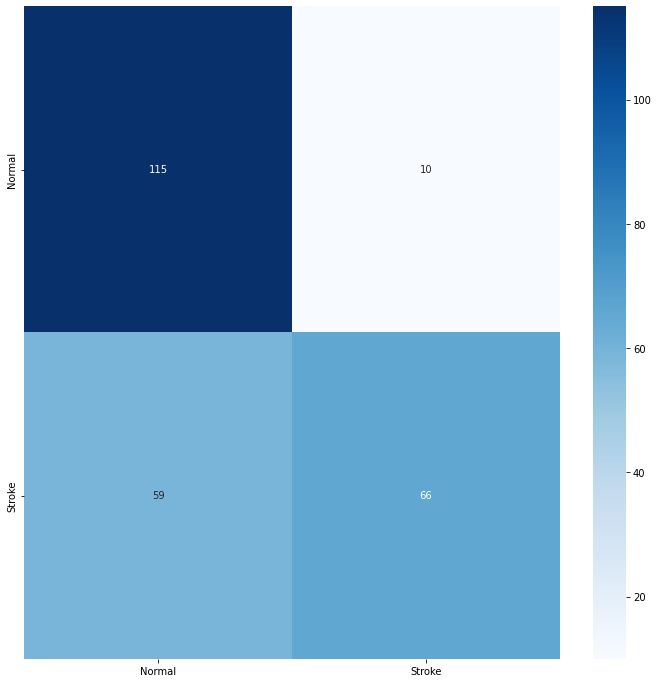

In [83]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Y_pred = model.predict(test_set)
y_pred = (Y_pred > 0.8).astype("int32")

print('\nClassification Report')
target_names = ['Normal', 'Stroke']
print(classification_report(test_set.classes, y_pred, target_names = target_names))

confusionmatrix = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(confusionmatrix)

plt.figure(figsize = (12, 12))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True, fmt="0.5g", xticklabels = target_names, yticklabels = target_names)

# EfficientNetB1

## Build Model

In [84]:
# create EfficientNetB1 base model
base_model = tf.keras.applications.EfficientNetB1(
    input_shape = INPUT_SHAPE,
    include_top = False,
    weights = 'imagenet',
    pooling='max')
base_model.trainable = True

x = base_model.output
x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=.45, seed=123)(x)        
predictions = Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_13 (Rescaling)       (None, 224, 224, 3)  0           ['input_17[0][0]']               
                                                                                                  
 normalization_13 (Normalizatio  (None, 224, 224, 3)  7          ['rescaling_13[0][0]']           
 n)                                                                                               
                                                                                           

In [85]:
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]
# model.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999), 
              metrics = metrics)

## Train Model

In [86]:
# train the model
start = datetime.now()
print(datetime.now())

callbacks = get_callbacks('efficientnetb1')
history = model.fit(train_set,
                    epochs = NUM_EPOCHS,
                    validation_data = valid_set,
                    callbacks = [callbacks])

end = datetime.now()
print(end-start)

2021-12-01 00:19:33.359561


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: 6.5597 - tp: 346.0000 - fp: 319.0000 - tn: 822.0000 - fn: 314.0000 - BinaryAccuracy: 0.6485 - precision: 0.5203 - recall: 0.5242 - auc: 0.6742
Epoch 00001: val_loss improved from inf to 4.89233, saving model to model.efficientnetb1.h5
57/57 [==============================] - 40s 426ms/step - loss: 6.5597 - tp: 346.0000 - fp: 319.0000 - tn: 822.0000 - fn: 314.0000 - BinaryAccuracy: 0.6485 - precision: 0.5203 - recall: 0.5242 - auc: 0.6742 - val_loss: 4.8923 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 285.0000 - val_fn: 165.0000 - val_BinaryAccuracy: 0.6333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5088 - lr: 0.0010
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 3.7501 - tp: 493.0000 - fp: 146.0000 - tn: 995.0000 - fn: 167.0000 - BinaryAccuracy: 0.8262 - precision: 0.7715 - recall: 0.7470 - auc: 0.8896
Epoch 00002: val_loss improved from 4.89233 to 3.11251, saving mode

## Evaluate Model

In [87]:
# get results
results = model.evaluate(valid_set, steps = len(valid_set), verbose = 1, return_dict = True)

15/15 [==============================] - 2s 94ms/step - loss: 0.9024 - tp: 75.0000 - fp: 35.0000 - tn: 250.0000 - fn: 90.0000 - BinaryAccuracy: 0.7222 - precision: 0.6818 - recall: 0.4545 - auc: 0.6940


In [88]:
# show results
print('EfficientNetB1:')
print('---------------')
print("ACCURACY:",(results['tp']+results['tn'])/(results['tp']+results['tn']+results['fp']+results['fn']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

EfficientNetB1:
---------------
ACCURACY: 0.7222222222222222
Binary Accuracy: 0.7222222089767456
Precision: 0.6818181872367859
Recall: 0.4545454680919647
AUC: 0.6940031051635742
F1 Score: 0.545454556941986


## Predict


Classification Report
              precision    recall  f1-score   support

      Normal       0.65      0.90      0.75       125
      Stroke       0.83      0.52      0.64       125

    accuracy                           0.71       250
   macro avg       0.74      0.71      0.70       250
weighted avg       0.74      0.71      0.70       250

Confusion Matrix
[[112  13]
 [ 60  65]]


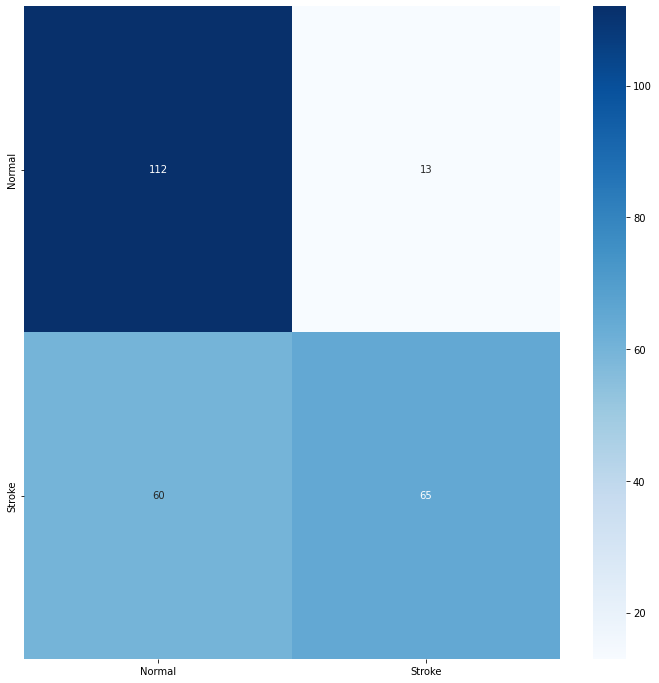

In [89]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Y_pred = model.predict(test_set)
y_pred = (Y_pred > 0.8).astype("int32")

print('\nClassification Report')
target_names = ['Normal', 'Stroke']
print(classification_report(test_set.classes, y_pred, target_names = target_names))

confusionmatrix = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(confusionmatrix)

plt.figure(figsize = (12, 12))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True, fmt="0.5g", xticklabels = target_names, yticklabels = target_names)

# EfficientNetB2

## Build Model

In [90]:
# create EfficientNetB0 base model
base_model = tf.keras.applications.EfficientNetB2(
    input_shape = INPUT_SHAPE,
    include_top = False,
    weights = 'imagenet',
    pooling='max')
base_model.trainable = True

x = base_model.output
x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=.45, seed=123)(x)        
predictions = Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

model.summary()

31801344/31790344 [==============================] - 0s 0us/step
Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_14 (Rescaling)       (None, 224, 224, 3)  0           ['input_18[0][0]']               
                                                                                                  
 normalization_14 (Normalizatio  (None, 224, 224, 3)  7          ['rescaling_14[0][0]']           
 n)                                                                                               
                          

In [91]:
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999), 
              metrics = metrics)

## Train Model

In [92]:
# train the model
start = datetime.now()
print(datetime.now())

callbacks = get_callbacks('efficientnetb2')
history = model.fit(train_set,
                    epochs = NUM_EPOCHS,
                    validation_data = valid_set,
                    callbacks = [callbacks])

end = datetime.now()
print(end-start)

2021-12-01 00:26:51.638331


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: 6.5191 - tp: 347.0000 - fp: 317.0000 - tn: 824.0000 - fn: 313.0000 - BinaryAccuracy: 0.6502 - precision: 0.5226 - recall: 0.5258 - auc: 0.6789
Epoch 00001: val_loss improved from inf to 6.27542, saving model to model.efficientnetb2.h5
57/57 [==============================] - 41s 440ms/step - loss: 6.5191 - tp: 347.0000 - fp: 317.0000 - tn: 824.0000 - fn: 313.0000 - BinaryAccuracy: 0.6502 - precision: 0.5226 - recall: 0.5258 - auc: 0.6789 - val_loss: 6.2754 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 285.0000 - val_fn: 165.0000 - val_BinaryAccuracy: 0.6333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4046 - lr: 0.0010
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 3.4621 - tp: 492.0000 - fp: 152.0000 - tn: 989.0000 - fn: 168.0000 - BinaryAccuracy: 0.8223 - precision: 0.7640 - recall: 0.7455 - auc: 0.8951
Epoch 00002: val_loss improved from 6.27542 to 2.99821, saving mode

## Evaluate Model

In [93]:
# get results
results = model.evaluate(valid_set, steps = len(valid_set), verbose = 1, return_dict = True)

15/15 [==============================] - 1s 93ms/step - loss: 0.7984 - tp: 86.0000 - fp: 49.0000 - tn: 236.0000 - fn: 79.0000 - BinaryAccuracy: 0.7156 - precision: 0.6370 - recall: 0.5212 - auc: 0.7354


In [94]:
# show results
print('EfficientNetB2:')
print('---------------')
print("ACCURACY:",(results['tp']+results['tn'])/(results['tp']+results['tn']+results['fp']+results['fn']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

EfficientNetB2:
---------------
ACCURACY: 0.7155555555555555
Binary Accuracy: 0.7155555486679077
Precision: 0.6370370388031006
Recall: 0.521212100982666
AUC: 0.7353748679161072
F1 Score: 0.5733333218097685


## Predict


Classification Report
              precision    recall  f1-score   support

      Normal       0.67      0.90      0.76       125
      Stroke       0.84      0.55      0.67       125

    accuracy                           0.72       250
   macro avg       0.75      0.72      0.72       250
weighted avg       0.75      0.72      0.72       250

Confusion Matrix
[[112  13]
 [ 56  69]]


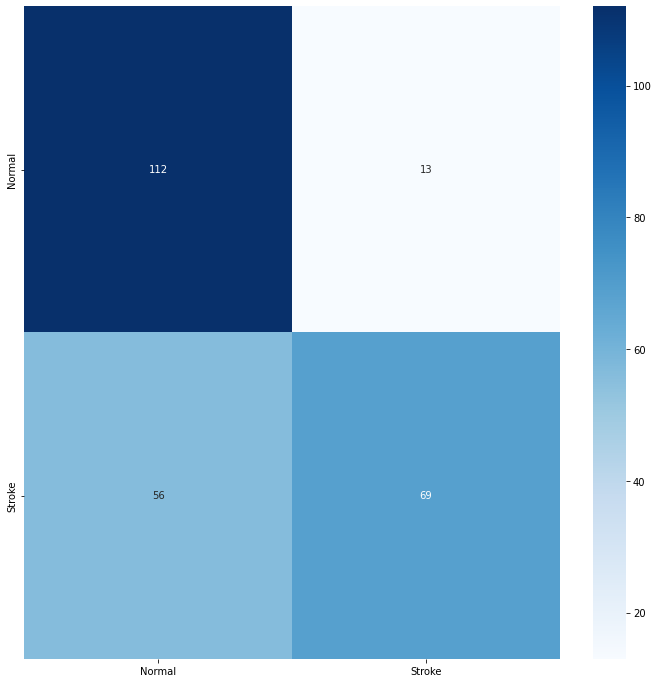

In [95]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Y_pred = model.predict(test_set)
y_pred = (Y_pred > 0.8).astype("int32")

print('\nClassification Report')
target_names = ['Normal', 'Stroke']
print(classification_report(test_set.classes, y_pred, target_names = target_names))

confusionmatrix = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(confusionmatrix)

plt.figure(figsize = (12, 12))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True, fmt="0.5g", xticklabels = target_names, yticklabels = target_names)

# EfficientNetB3

## Build Model

In [96]:
# create EfficientNetB3 base model
base_model = tf.keras.applications.EfficientNetB3(
    input_shape = INPUT_SHAPE,
    include_top = False,
    weights = 'imagenet',
    pooling='max')
base_model.trainable = True

x = base_model.output
x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=.45, seed=123)(x)        
predictions = Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

model.summary()

43950080/43941136 [==============================] - 0s 0us/step
Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_15 (Rescaling)       (None, 224, 224, 3)  0           ['input_19[0][0]']               
                                                                                                  
 normalization_15 (Normalizatio  (None, 224, 224, 3)  7          ['rescaling_15[0][0]']           
 n)                                                                                               
                          

In [97]:
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999), 
              metrics = metrics)

## Train Model

In [98]:
# train the model
start = datetime.now()
print(datetime.now())

callbacks = get_callbacks('efficientnetb3')
history = model.fit(train_set,
                    epochs = NUM_EPOCHS,
                    validation_data = valid_set,
                    callbacks = [callbacks])

end = datetime.now()
print(end-start)

2021-12-01 00:34:20.547412


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: 6.5870 - tp: 397.0000 - fp: 292.0000 - tn: 849.0000 - fn: 263.0000 - BinaryAccuracy: 0.6918 - precision: 0.5762 - recall: 0.6015 - auc: 0.7274
Epoch 00001: val_loss improved from inf to 4.79205, saving model to model.efficientnetb3.h5
57/57 [==============================] - 50s 540ms/step - loss: 6.5870 - tp: 397.0000 - fp: 292.0000 - tn: 849.0000 - fn: 263.0000 - BinaryAccuracy: 0.6918 - precision: 0.5762 - recall: 0.6015 - auc: 0.7274 - val_loss: 4.7921 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 285.0000 - val_fn: 165.0000 - val_BinaryAccuracy: 0.6333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5779 - lr: 0.0010
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 3.7644 - tp: 481.0000 - fp: 162.0000 - tn: 979.0000 - fn: 179.0000 - BinaryAccuracy: 0.8107 - precision: 0.7481 - recall: 0.7288 - auc: 0.8746
Epoch 00002: val_loss improved from 4.79205 to 3.17724, saving mode

## Evaluate Model

In [99]:
# get results
results = model.evaluate(valid_set, steps = len(valid_set), verbose = 1, return_dict = True)

15/15 [==============================] - 2s 98ms/step - loss: 0.8131 - tp: 89.0000 - fp: 27.0000 - tn: 258.0000 - fn: 76.0000 - BinaryAccuracy: 0.7711 - precision: 0.7672 - recall: 0.5394 - auc: 0.7877


In [100]:
# show results
print('EfficientNetB3:')
print('---------------')
print("ACCURACY:",(results['tp']+results['tn'])/(results['tp']+results['tn']+results['fp']+results['fn']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

EfficientNetB3:
---------------
ACCURACY: 0.7711111111111111
Binary Accuracy: 0.7711111307144165
Precision: 0.767241358757019
Recall: 0.539393961429596
AUC: 0.7876661419868469
F1 Score: 0.6334519654856238


## Predict


Classification Report
              precision    recall  f1-score   support

      Normal       0.76      0.92      0.83       125
      Stroke       0.90      0.71      0.79       125

    accuracy                           0.82       250
   macro avg       0.83      0.82      0.81       250
weighted avg       0.83      0.82      0.81       250

Confusion Matrix
[[115  10]
 [ 36  89]]


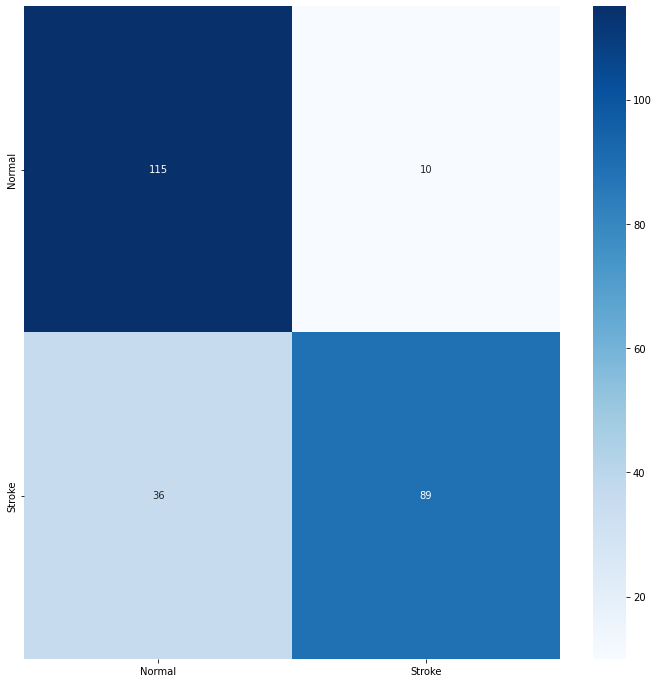

In [101]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Y_pred = model.predict(test_set)
y_pred = (Y_pred > 0.8).astype("int32")

print('\nClassification Report')
target_names = ['Normal', 'Stroke']
print(classification_report(test_set.classes, y_pred, target_names = target_names))

confusionmatrix = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(confusionmatrix)

plt.figure(figsize = (12, 12))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True, fmt="0.5g", xticklabels = target_names, yticklabels = target_names)

# EfficientNetB4

## Build Model

In [102]:
# create EfficientNetB4 base model
base_model = tf.keras.applications.EfficientNetB4(
    input_shape = INPUT_SHAPE,
    include_top = False,
    weights = 'imagenet',
    pooling='max')
base_model.trainable = True

x = base_model.output
x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=.45, seed=123)(x)        
predictions = Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

model.summary()

71696384/71686520 [==============================] - 1s 0us/step
Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_16 (Rescaling)       (None, 224, 224, 3)  0           ['input_20[0][0]']               
                                                                                                  
 normalization_16 (Normalizatio  (None, 224, 224, 3)  7          ['rescaling_16[0][0]']           
 n)                                                                                               
                          

In [103]:
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999), 
              metrics = metrics)

## Train Model

In [104]:
# train the model
start = datetime.now()
print(datetime.now())

callbacks = get_callbacks('efficientnetb4')
history = model.fit(train_set,
                    epochs = NUM_EPOCHS,
                    validation_data = valid_set,
                    callbacks = [callbacks])

end = datetime.now()
print(end-start)

2021-12-01 00:43:29.448373


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: 6.6383 - tp: 337.0000 - fp: 301.0000 - tn: 840.0000 - fn: 323.0000 - BinaryAccuracy: 0.6535 - precision: 0.5282 - recall: 0.5106 - auc: 0.6764
Epoch 00001: val_loss improved from inf to 4.61906, saving model to model.efficientnetb4.h5
57/57 [==============================] - 60s 647ms/step - loss: 6.6383 - tp: 337.0000 - fp: 301.0000 - tn: 840.0000 - fn: 323.0000 - BinaryAccuracy: 0.6535 - precision: 0.5282 - recall: 0.5106 - auc: 0.6764 - val_loss: 4.6191 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 285.0000 - val_fn: 165.0000 - val_BinaryAccuracy: 0.6333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5169 - lr: 0.0010
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 3.9727 - tp: 370.0000 - fp: 163.0000 - tn: 978.0000 - fn: 290.0000 - BinaryAccuracy: 0.7485 - precision: 0.6942 - recall: 0.5606 - auc: 0.7911
Epoch 00002: val_loss improved from 4.61906 to 3.32475, saving mode

## Evaluate Model

In [105]:
# get results
results = model.evaluate(valid_set, steps = len(valid_set), verbose = 1, return_dict = True)

15/15 [==============================] - 2s 100ms/step - loss: 1.2190 - tp: 49.0000 - fp: 33.0000 - tn: 252.0000 - fn: 116.0000 - BinaryAccuracy: 0.6689 - precision: 0.5976 - recall: 0.2970 - auc: 0.6317


In [106]:
# show results
print('EfficientNetB4:')
print('---------------')
print("ACCURACY:",(results['tp']+results['tn'])/(results['tp']+results['tn']+results['fp']+results['fn']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

EfficientNetB4:
---------------
ACCURACY: 0.6688888888888889
Binary Accuracy: 0.6688888669013977
Precision: 0.5975610017776489
Recall: 0.2969697117805481
AUC: 0.631663978099823
F1 Score: 0.3967611525898911


## Predict


Classification Report
              precision    recall  f1-score   support

      Normal       0.65      0.90      0.75       125
      Stroke       0.83      0.52      0.64       125

    accuracy                           0.71       250
   macro avg       0.74      0.71      0.70       250
weighted avg       0.74      0.71      0.70       250

Confusion Matrix
[[112  13]
 [ 60  65]]


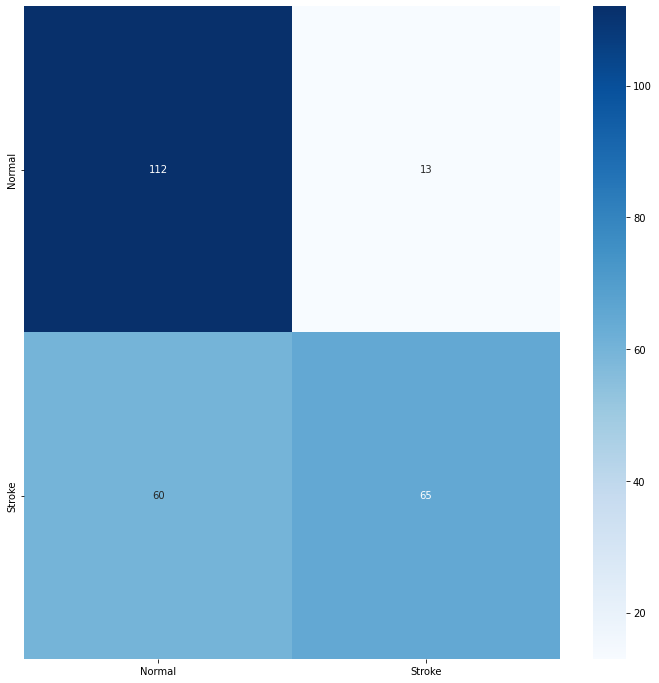

In [107]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Y_pred = model.predict(test_set)
y_pred = (Y_pred > 0.8).astype("int32")

print('\nClassification Report')
target_names = ['Normal', 'Stroke']
print(classification_report(test_set.classes, y_pred, target_names = target_names))

confusionmatrix = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(confusionmatrix)

plt.figure(figsize = (12, 12))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True, fmt="0.5g", xticklabels = target_names, yticklabels = target_names)

# EfficientNetB5

## Build Model

In [108]:
# create EfficientNetB5 base model
base_model = tf.keras.applications.EfficientNetB5(
    input_shape = INPUT_SHAPE,
    include_top = False,
    weights = 'imagenet',
    pooling='max')
base_model.trainable = True

x = base_model.output
x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=.45, seed=123)(x)        
predictions = Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

model.summary()

115277824/115263384 [==============================] - 1s 0us/step
Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_17 (Rescaling)       (None, 224, 224, 3)  0           ['input_21[0][0]']               
                                                                                                  
 normalization_17 (Normalizatio  (None, 224, 224, 3)  7          ['rescaling_17[0][0]']           
 n)                                                                                               
                        

In [109]:
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999), 
              metrics = metrics)

## Train Model

In [110]:
# train the model
start = datetime.now()
print(datetime.now())

callbacks = get_callbacks('efficientnetb5')
history = model.fit(train_set,
                    epochs = NUM_EPOCHS,
                    validation_data = valid_set,
                    callbacks = [callbacks])

end = datetime.now()
print(end-start)

2021-12-01 00:54:39.908065


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: 6.9964 - tp: 386.0000 - fp: 327.0000 - tn: 814.0000 - fn: 274.0000 - BinaryAccuracy: 0.6663 - precision: 0.5414 - recall: 0.5848 - auc: 0.7056
Epoch 00001: val_loss improved from inf to 5.06783, saving model to model.efficientnetb5.h5
57/57 [==============================] - 78s 864ms/step - loss: 6.9964 - tp: 386.0000 - fp: 327.0000 - tn: 814.0000 - fn: 274.0000 - BinaryAccuracy: 0.6663 - precision: 0.5414 - recall: 0.5848 - auc: 0.7056 - val_loss: 5.0678 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 285.0000 - val_fn: 165.0000 - val_BinaryAccuracy: 0.6333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3009 - lr: 0.0010
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 3.8729 - tp: 532.0000 - fp: 141.0000 - tn: 1000.0000 - fn: 128.0000 - BinaryAccuracy: 0.8506 - precision: 0.7905 - recall: 0.8061 - auc: 0.9053
Epoch 00002: val_loss improved from 5.06783 to 3.39933, saving mod

## Evaluate Model

In [111]:
# get results
results = model.evaluate(valid_set, steps = len(valid_set), verbose = 1, return_dict = True)

15/15 [==============================] - 2s 126ms/step - loss: 0.9518 - tp: 70.0000 - fp: 20.0000 - tn: 265.0000 - fn: 95.0000 - BinaryAccuracy: 0.7444 - precision: 0.7778 - recall: 0.4242 - auc: 0.7536


In [112]:
# show results
print('EfficientNetB5:')
print('---------------')
print("ACCURACY:",(results['tp']+results['tn'])/(results['tp']+results['tn']+results['fp']+results['fn']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

EfficientNetB5:
---------------
ACCURACY: 0.7444444444444445
Binary Accuracy: 0.7444444298744202
Precision: 0.7777777910232544
Recall: 0.42424243688583374
AUC: 0.7535565495491028
F1 Score: 0.5490196217302632


## Predict


Classification Report
              precision    recall  f1-score   support

      Normal       0.69      0.96      0.81       125
      Stroke       0.94      0.58      0.71       125

    accuracy                           0.77       250
   macro avg       0.81      0.77      0.76       250
weighted avg       0.81      0.77      0.76       250

Confusion Matrix
[[120   5]
 [ 53  72]]


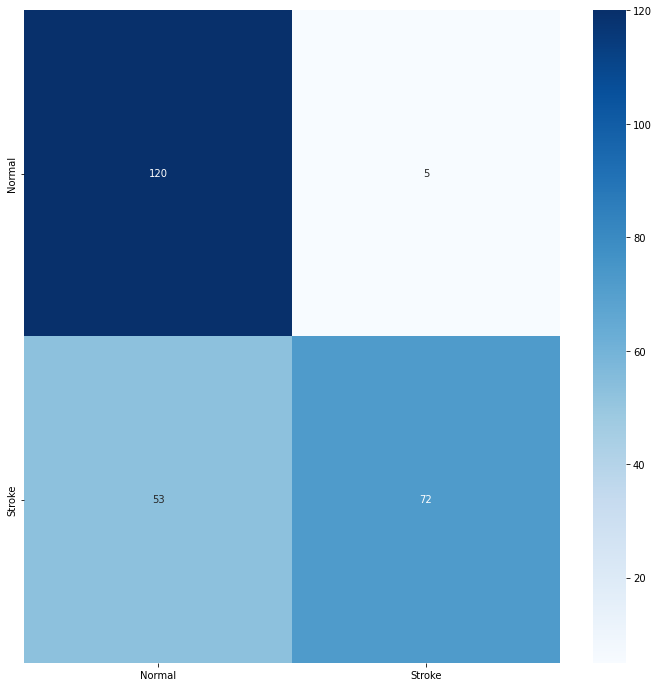

In [113]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Y_pred = model.predict(test_set)
y_pred = (Y_pred > 0.8).astype("int32")

print('\nClassification Report')
target_names = ['Normal', 'Stroke']
print(classification_report(test_set.classes, y_pred, target_names = target_names))

confusionmatrix = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(confusionmatrix)

plt.figure(figsize = (12, 12))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True, fmt="0.5g", xticklabels = target_names, yticklabels = target_names)

# EfficientNetB6

## Build Model

In [114]:
# create EfficientNetB4 base model
base_model = tf.keras.applications.EfficientNetB6(
    input_shape = INPUT_SHAPE,
    include_top = False,
    weights = 'imagenet',
    pooling='max')
base_model.trainable = True

x = base_model.output
x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=.45, seed=123)(x)        
predictions = Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

model.summary()

165249024/165234480 [==============================] - 1s 0us/step
Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_18 (Rescaling)       (None, 224, 224, 3)  0           ['input_22[0][0]']               
                                                                                                  
 normalization_18 (Normalizatio  (None, 224, 224, 3)  7          ['rescaling_18[0][0]']           
 n)                                                                                               
                        

In [115]:
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999), 
              metrics = metrics)

## Train Model

In [116]:
# train the model
start = datetime.now()
print(datetime.now())

callbacks = get_callbacks('efficientnetb6')
history = model.fit(train_set,
                    epochs = NUM_EPOCHS,
                    validation_data = valid_set,
                    callbacks = [callbacks])

end = datetime.now()
print(end-start)

2021-12-01 01:09:34.331125


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: 6.8912 - tp: 304.0000 - fp: 294.0000 - tn: 847.0000 - fn: 356.0000 - BinaryAccuracy: 0.6391 - precision: 0.5084 - recall: 0.4606 - auc: 0.6527
Epoch 00001: val_loss improved from inf to 33.65893, saving model to model.efficientnetb6.h5
57/57 [==============================] - 95s 1s/step - loss: 6.8912 - tp: 304.0000 - fp: 294.0000 - tn: 847.0000 - fn: 356.0000 - BinaryAccuracy: 0.6391 - precision: 0.5084 - recall: 0.4606 - auc: 0.6527 - val_loss: 33.6589 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 285.0000 - val_fn: 165.0000 - val_BinaryAccuracy: 0.6333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - lr: 0.0010
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 4.2511 - tp: 351.0000 - fp: 277.0000 - tn: 864.0000 - fn: 309.0000 - BinaryAccuracy: 0.6746 - precision: 0.5589 - recall: 0.5318 - auc: 0.7014
Epoch 00002: val_loss improved from 33.65893 to 14.25038, saving mod

## Evaluate Model

In [117]:
# get results
results = model.evaluate(valid_set, steps = len(valid_set), verbose = 1, return_dict = True)

15/15 [==============================] - 3s 163ms/step - loss: 0.8987 - tp: 60.0000 - fp: 9.0000 - tn: 276.0000 - fn: 105.0000 - BinaryAccuracy: 0.7467 - precision: 0.8696 - recall: 0.3636 - auc: 0.7703


In [118]:
# show results
print('EfficientNetB6:')
print('---------------')
print("ACCURACY:",(results['tp']+results['tn'])/(results['tp']+results['tn']+results['fp']+results['fn']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

EfficientNetB6:
---------------
ACCURACY: 0.7466666666666667
Binary Accuracy: 0.746666669845581
Precision: 0.8695651888847351
Recall: 0.3636363744735718
AUC: 0.7703242301940918
F1 Score: 0.5128205186399007


## Predict


Classification Report
              precision    recall  f1-score   support

      Normal       0.65      0.99      0.79       125
      Stroke       0.98      0.47      0.64       125

    accuracy                           0.73       250
   macro avg       0.82      0.73      0.71       250
weighted avg       0.82      0.73      0.71       250

Confusion Matrix
[[124   1]
 [ 66  59]]


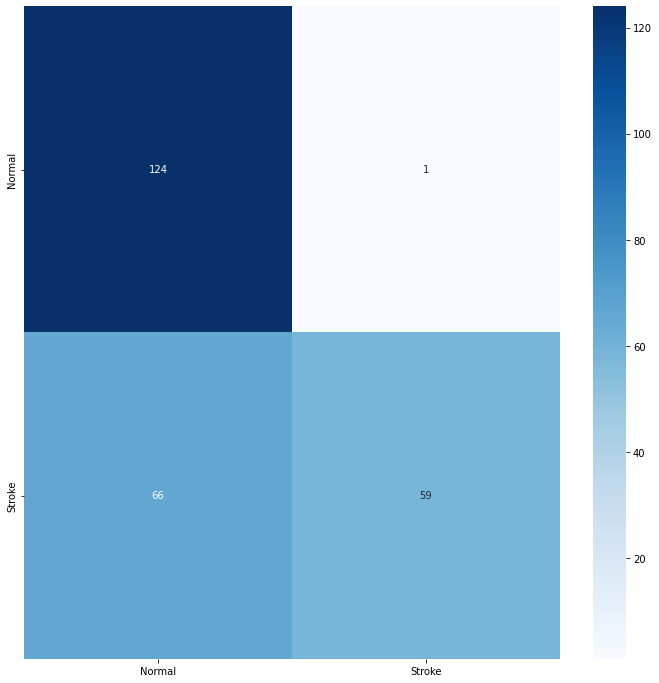

In [119]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Y_pred = model.predict(test_set)
y_pred = (Y_pred > 0.8).astype("int32")

print('\nClassification Report')
target_names = ['Normal', 'Stroke']
print(classification_report(test_set.classes, y_pred, target_names = target_names))

confusionmatrix = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(confusionmatrix)

plt.figure(figsize = (12, 12))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True, fmt="0.5g", xticklabels = target_names, yticklabels = target_names)

# ViT B16

## Build Model

In [123]:
# build vit model with 16 patch_size
base_model = vit.vit_b16(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

x = base_model.output
x = tf.keras.layers.Flatten()(x)
predictions = Dense(1, activation = 'sigmoid', name = 'Final')(x)
model = tf.keras.models.Model(inputs = base_model.input, outputs = predictions)

model.summary()

/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  UserWarning,


Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 768)       590592    
                                                                 
 reshape_3 (Reshape)         (None, 196, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 197, 768)          768       
                                                                 
 Transformer/posembed_input   (None, 197, 768)         151296    
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 197, 768),       7087872   
 (TransformerBlock)           (None, 12, None, None))     

In [124]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(loss = 'binary_crossentropy', 
              optimizer = tfa.optimizers.RectifiedAdam(learning_rate = LEARNING_RATE, beta_1 = 0.9, beta_2 = 0.999), 
              metrics = metrics)

## Train Model

In [125]:
# train the model
start = datetime.now()
print(datetime.now())

callbacks = get_callbacks('vitb16')
history = model.fit(train_set,
                    epochs = NUM_EPOCHS,
                    validation_data = valid_set,
                    callbacks = [callbacks])

end = datetime.now()
print(end-start)

2021-12-01 01:32:25.147617
Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: 0.5881 - tp: 307.0000 - fp: 211.0000 - tn: 930.0000 - fn: 353.0000 - BinaryAccuracy: 0.6868 - precision: 0.5927 - recall: 0.4652 - auc: 0.7269
Epoch 00001: val_loss improved from inf to 0.55410, saving model to model.vitb16.h5
57/57 [==============================] - 87s 959ms/step - loss: 0.5881 - tp: 307.0000 - fp: 211.0000 - tn: 930.0000 - fn: 353.0000 - BinaryAccuracy: 0.6868 - precision: 0.5927 - recall: 0.4652 - auc: 0.7269 - val_loss: 0.5541 - val_tp: 84.0000 - val_fp: 68.0000 - val_tn: 217.0000 - val_fn: 81.0000 - val_BinaryAccuracy: 0.6689 - val_precision: 0.5526 - val_recall: 0.5091 - val_auc: 0.7949 - lr: 0.0010
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 0.2785 - tp: 542.0000 - fp: 100.0000 - tn: 1041.0000 - fn: 118.0000 - BinaryAccuracy: 0.8790 - precision: 0.8442 - recall: 0.8212 - auc: 0.9472
Epoch 00002: val_loss did not improve from 0.55410
57/57 [====

## Evaluate Model

In [126]:
# get results
results = model.evaluate(valid_set, steps = len(valid_set), verbose = 1, return_dict = True)

15/15 [==============================] - 4s 247ms/step - loss: 2.6255 - tp: 80.0000 - fp: 73.0000 - tn: 212.0000 - fn: 85.0000 - BinaryAccuracy: 0.6489 - precision: 0.5229 - recall: 0.4848 - auc: 0.6553


In [127]:
# show results
print('ViT:')
print('---------------')
print("ACCURACY:",(results['tp']+results['tn'])/(results['tp']+results['tn']+results['fp']+results['fn']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

ViT:
---------------
ACCURACY: 0.6488888888888888
Binary Accuracy: 0.648888885974884
Precision: 0.5228758454322815
Recall: 0.4848484992980957
AUC: 0.6552897095680237
F1 Score: 0.5031446750349062


## Predict


Classification Report
              precision    recall  f1-score   support

      Normal       0.66      0.92      0.77       125
      Stroke       0.87      0.54      0.66       125

    accuracy                           0.73       250
   macro avg       0.77      0.73      0.72       250
weighted avg       0.77      0.73      0.72       250

Confusion Matrix
[[115  10]
 [ 58  67]]


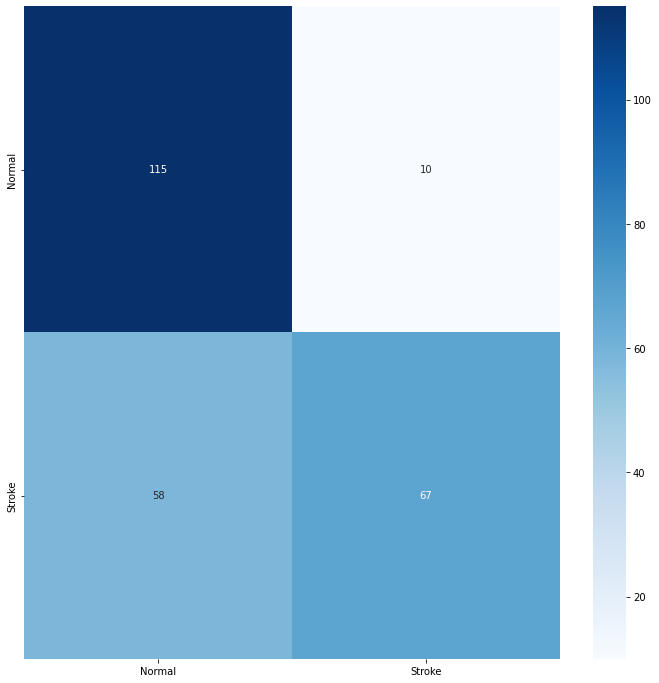

In [128]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Y_pred = model.predict(test_set)
y_pred = (Y_pred > 0.8).astype("int32")

print('\nClassification Report')
target_names = ['Normal', 'Stroke']
print(classification_report(test_set.classes, y_pred, target_names = target_names))

confusionmatrix = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(confusionmatrix)

plt.figure(figsize = (12, 12))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True, fmt="0.5g", xticklabels = target_names, yticklabels = target_names)

# ViT B32

## Build Model

In [129]:
# build vit model with 32 patch_size
base_model = vit.vit_b32(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

x = base_model.output
x = tf.keras.layers.Flatten()(x)
predictions = Dense(1, activation = 'sigmoid', name = 'Final')(x)
model = tf.keras.models.Model(inputs = base_model.input, outputs = predictions)

model.summary()

/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  UserWarning,


Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 7, 7, 768)         2360064   
                                                                 
 reshape_4 (Reshape)         (None, 49, 768)           0         
                                                                 
 class_token (ClassToken)    (None, 50, 768)           768       
                                                                 
 Transformer/posembed_input   (None, 50, 768)          38400     
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 50, 768),        7087872   
 (TransformerBlock)           (None, 12, None, None))     

In [130]:
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(loss = 'binary_crossentropy', 
              optimizer = tfa.optimizers.RectifiedAdam(learning_rate = LEARNING_RATE, beta_1 = 0.9, beta_2 = 0.999), 
              metrics = metrics)

## Train Model

In [131]:
# train the model
start = datetime.now()
print(datetime.now())

callbacks = get_callbacks('vitb32')
history = model.fit(train_set,
                    epochs = NUM_EPOCHS,
                    validation_data = valid_set,
                    callbacks = [callbacks])

end = datetime.now()
print(end-start)

2021-12-01 01:49:04.937290
Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: 0.6404 - tp: 295.0000 - fp: 251.0000 - tn: 890.0000 - fn: 365.0000 - BinaryAccuracy: 0.6580 - precision: 0.5403 - recall: 0.4470 - auc: 0.6817
Epoch 00001: val_loss improved from inf to 0.55380, saving model to model.vitb32.h5
57/57 [==============================] - 58s 433ms/step - loss: 0.6404 - tp: 295.0000 - fp: 251.0000 - tn: 890.0000 - fn: 365.0000 - BinaryAccuracy: 0.6580 - precision: 0.5403 - recall: 0.4470 - auc: 0.6817 - val_loss: 0.5538 - val_tp: 105.0000 - val_fp: 76.0000 - val_tn: 209.0000 - val_fn: 60.0000 - val_BinaryAccuracy: 0.6978 - val_precision: 0.5801 - val_recall: 0.6364 - val_auc: 0.7725 - lr: 0.0010
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 0.2870 - tp: 544.0000 - fp: 97.0000 - tn: 1044.0000 - fn: 116.0000 - BinaryAccuracy: 0.8817 - precision: 0.8487 - recall: 0.8242 - auc: 0.9471
Epoch 00002: val_loss did not improve from 0.55380
57/57 [====

## Evaluate Model

In [132]:
# get results
results = model.evaluate(valid_set, steps = len(valid_set), verbose = 1, return_dict = True)

15/15 [==============================] - 2s 102ms/step - loss: 2.0822 - tp: 64.0000 - fp: 27.0000 - tn: 258.0000 - fn: 101.0000 - BinaryAccuracy: 0.7156 - precision: 0.7033 - recall: 0.3879 - auc: 0.7117


In [133]:
# show results
print('ViT:')
print('---------------')
print("ACCURACY:",(results['tp']+results['tn'])/(results['tp']+results['tn']+results['fp']+results['fn']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

ViT:
---------------
ACCURACY: 0.7155555555555555
Binary Accuracy: 0.7155555486679077
Precision: 0.7032967209815979
Recall: 0.38787877559661865
AUC: 0.7116532921791077
F1 Score: 0.499999994264726


## Predict


Classification Report
              precision    recall  f1-score   support

      Normal       0.71      0.98      0.83       125
      Stroke       0.97      0.60      0.74       125

    accuracy                           0.79       250
   macro avg       0.84      0.79      0.78       250
weighted avg       0.84      0.79      0.78       250

Confusion Matrix
[[123   2]
 [ 50  75]]


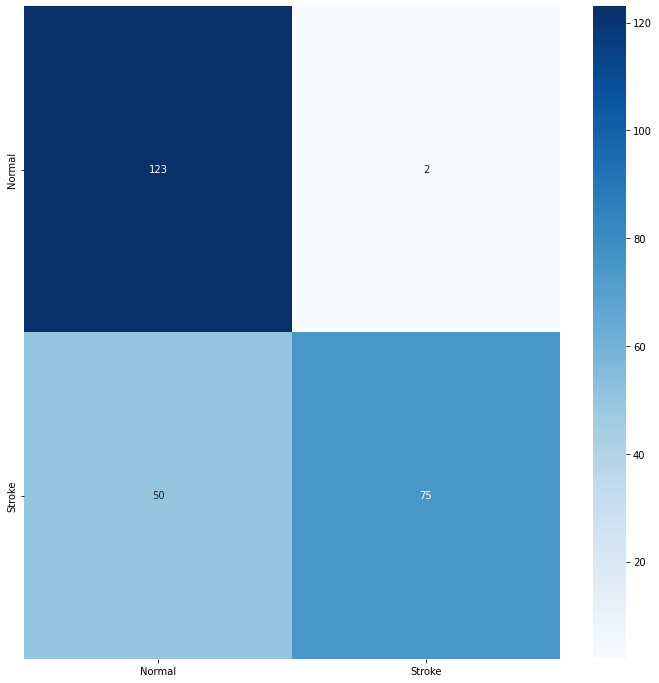

In [134]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Y_pred = model.predict(test_set)
y_pred = (Y_pred > 0.8).astype("int32")

print('\nClassification Report')
target_names = ['Normal', 'Stroke']
print(classification_report(test_set.classes, y_pred, target_names = target_names))

confusionmatrix = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(confusionmatrix)

plt.figure(figsize = (12, 12))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True, fmt="0.5g", xticklabels = target_names, yticklabels = target_names)